# Cross-validation and intuition

In this notebook, we will look at how to do cross-validation in Python and build some intuition about what happens when some of our implicit assumptions about our data breaks down. We will specifically look at what happens when we train on datasets that are too small or non-representative, and look at how to include interaction terms in our models. 

## Background

We will continue using the dataset provided by Cogo Labs that we've used in previous labs. Recall that we are trying to predict customers' email open rates. 

## Setup

Lets start by importing the necessary libraries and mounting the Google Drive:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import the data

The dataset we will use is the same that we used for the labs on descriptive analytics; refer to the earlier
descriptions for details. Let’s load the training data. Change the path below to accurately reflect the location
of the data on your Drive.

In [2]:
df = pd.read_csv('/content/drive/My Drive/MLBA/cogo-all.tsv', sep='\t')

## Train and Test Sets

We start by splitting the data into a training and testing set. We've done this manually before, but today we'll use Scikit-learn's `train_test_split` function. 

In [3]:
X = df.loc[:, df.columns != "p_open"] 
y = df["p_open"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((230638, 16), (57660, 16), (230638,), (57660,))

The training data contains 173276 observations. This will slow down training. Let’s take a random subsample
of the training set to train on. Then, when we are happy with the tuning of our algorithms, we can increase
the size of the training set further. 

In [5]:
df_train = X_train.copy()

# Add p_open to the combined training dataframe
df_train["p_open"] = y_train 

# Randomly sample 5000 rows from the training data
train_sample_size = 5000
df_train_sample = df_train.sample(n=train_sample_size, random_state=5) 

df_train_sample.shape

(5000, 17)

## Data Preparation

Instead of training the model on every predictor of the data, we can train it using a subset of the predictors. Lets start by training a linear regression model with three predictors

In [6]:
# it's up to you to add more predictors as you see fit
predictors1 = ["browser1", "browser2", "browser3"]

X_train_sample_p1 = df_train_sample[predictors1]
y_train_sample = df_train_sample["p_open"][:, np.newaxis]

X_test_p1 = X_test[predictors1]
y_train_sample.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


(5000, 1)

## Linear Regression (recap)

We've already seen how to train a linear regression model, inspect its coefficients and compute mean squared error. 

In [ ]:
from sklearn.metrics import mean_squared_error

# Create a linear regression object lr_model
# Train the model
# Predict
# Evaluate, store results in mse_train_lr

print("intercept: ", lr_model.intercept_)
print("coefficients: ", lr_model.coef_)
print("train mse: ", mse_train_lr, np.sqrt(mse_train_lr))

In [8]:
from sklearn.metrics import mean_squared_error

# Create a linear regression object
lr_model = LinearRegression()
# Train the model
lr_model.fit(X_train_sample_p1, y_train_sample)
# Predict
yhat_train_lr = lr_model.predict(X_train_sample_p1)
# Evaluate
mse_train_lr = mean_squared_error(y_train_sample, yhat_train_lr)
#mse_train_lr = np.mean((y_train_sample - yhat_train_lr)**2)

print("intercept: ", lr_model.intercept_)
print("coefficients: ", lr_model.coef_)
print("train mse: ", mse_train_lr, np.sqrt(mse_train_lr))

intercept:  [0.07390363]
coefficients:  [[0.00719408 0.00413649 0.03834116]]
train mse:  0.028116012787471698 0.16767830148075719


So, we have $MSE_{Train} \approx 0.0281$. It’s a start. Now is a good time to recall that OLS minimizes the sum least of squares, i.e., the following objective function: $MSE_{Train} = \sum_{i}^{n} (y_i - \hat{y_i})^2$ where $\hat{y_i} = \beta_0 + \sum_{i}^{p} \beta_i x_i$.  To get a sense of how accurate our predictions are, we can take the root of the MSE, in this case $\sqrt{MSE_{Train}} \approx 0.167$, so on average our prediction of open rate is off by about 17%.

We should also compute MSE on the test set, which is what we really care about.

In [9]:
yhat_test_lr = lr_model.predict(X_test_p1)
mse_test_lr = mean_squared_error(y_test, yhat_test_lr)
print(mse_test_lr)

0.028703277011135748


Slightly higher than than our training error, but not so much that we should be worried. 

## Cross-validation
We discussed how cross-validation gives us more accurate error estimates by repeatedly treating a different subset of our data as validation set. Scikit-learn has built-in functions for cross-validation. 

We will use the `cross_val_score` function, which has three required arguments when doing supervised learning: a classifier, your data (`X`), and your outcomes (`y`). The optional argument `cv` let's you set the number of folds you want to use. 
The  `scoring` argument evaluates several known scoring rules automatically so that you don't have to compute the error rate by hand. The available scoring rules are discussed [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter). 

In [10]:
from sklearn.model_selection import cross_val_score
# Instantiate a linear regression model
lr_model = LinearRegression()
cross_val_score(lr_model, X_train_sample_p1, y_train_sample, cv=5, scoring='neg_mean_squared_error')

array([-0.02349767, -0.02990607, -0.03134196, -0.03032754, -0.02571717])

Notice that it returns negative mean squared error by default (but this is easy enough to negate). Now that we have the accuracy on every fold, we can compute our final accuracy estimate. 

In [11]:
lr_cv5_scores = cross_val_score(lr_model, X_train_sample_p1, y_train_sample, cv=5, scoring='neg_mean_squared_error')
mse_lr_cv5 = np.mean(-lr_cv5_scores)
print(mse_lr_cv5)

0.028158083587366184


### Cross-validation for parameter selection

Recall that Lasso and Ridge have a regularization parameter $\lambda$ which must be tuned. One way to tune this would be to use the `cross_val_score` function several times, once for each of the parameter values you are considering.  You should try to implement this to make sure you understand the steps. 

In [12]:
# dont need. 
predictors2 = ['browser1', 'browser2', 'browser3', 'activity_recency', 'activity_observations', 'activity_days', 'activity_locations', 'age' ]
X_train_sample_p2 = df_train_sample[predictors2]
X_test_p2 = X_test[predictors2]

In [ ]:
from sklearn.linear_model import Ridge, Lasso

lambdas = np.logspace(-3, 7, num=10)
cv_scores = []

for lam in lambdas: 
  # instantiate a ridge model with the current lambda (lam)
  # do 5-fold cross-validation and store the results in cv_scores

plt.plot(lambdas, cv_scores)
plt.xscale('log')

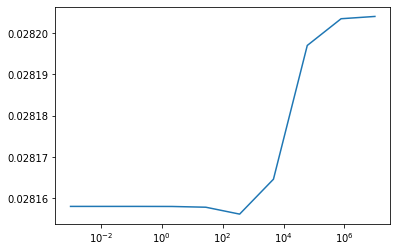

In [18]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lambdas = np.logspace(-3, 7, num=10)
cv_scores = []

for l in lambdas: 
  ridge =  make_pipeline( StandardScaler(), Ridge(alpha=l) )
  this_cv_scores = cross_val_score(ridge, X_train_sample_p1, y_train_sample, cv=5, scoring='neg_mean_squared_error')
  cv_scores.append(np.mean(-this_cv_scores))

plt.plot(lambdas, cv_scores)
plt.xscale('log')

Now that we have our cross-validation estimates for each parameter, we should train a model on the entire training set using the best parameter. This is the model we will evaluate on the test set. 

In [20]:
min_idx = np.argmin(cv_scores)
ridge_final = make_pipeline( StandardScaler(), Ridge(alpha=lambdas[min_idx]) )
ridge_final.fit(X_train_sample_p1, y_train_sample)
yhat_ridge = ridge_final.predict(X_test[predictors1])
mse_ridge_test = mean_squared_error(y_test, yhat_ridge)
print(mse_ridge_test)

0.02870780370856948


Of course, this is a common task in machine learning, so functions exist to automate it. In particular, you should take a look at  [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) and [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html), which allow you to specify a vector (or number) of $\lambda$'s (called alphas here) to try as well as the number of folds used for the cross-validation. 

## Building intuition: Adding predictors to your model

The models we have fit thusfar have been very simple, they only used browser data to predict open rates.
Try fitting more complex models by including additional predictors like activity_recency etc., how does
this affect $MSE_{Train}$ and $MSE_{Test}$?

In [ ]:
predictors2 = ['browser1', 'browser2', 'browser3', 'activity_recency', 'activity_observations', 'activity_days', 'activity_locations', 'age' ]

X_train_sample_p2 = df_train_sample[predictors2]
y_train_sample = df_train_sample["p_open"]

lr_model = LinearRegression()
lr_model.fit( ... )

#evaluate on training set

#evaluate on test set

print(mse_train_lr_p2, mse_test_lr_p2)

In [22]:
predictors2 = ['browser1', 'browser2', 'browser3', 'activity_recency', 'activity_observations', 'activity_days', 'activity_locations', 'age' ]

X_train_sample_p2 = df_train_sample[predictors2]
y_train_sample = df_train_sample["p_open"]

lr_model = make_pipeline( StandardScaler(), LinearRegression())
lr_model.fit(X_train_sample_p2, y_train_sample)

#evaluate on training set
yhat_train_lr = lr_model.predict(X_train_sample_p2)
mse_train_lr = np.mean(np.square(y_train_sample - yhat_train_lr))

#evaluate on test set
yhat_test_lr = lr_model.predict(X_test[predictors2])
mse_test_lr = np.mean(np.square(y_test - yhat_test_lr))

print(mse_train_lr, mse_test_lr)

0.027685618004062832 0.028445095988509025


Notice this causes a significant improvement in training error, but the improvement in testing error is much smaller. We may even be overfitting a little here.  

You can also add new predictors to the data set, for example, recall that we saw a clear divide in open rates
by state. Perhaps adding a predictor that says whether a state is ‘high’ or ‘low’ will help.

## Building intuition: Training on a small sample

What do you expect would happen if we trained on a very small sample of the training set, say only 30
observations? The following code takes a subset of the data.

In [23]:
train_sample_size = 30
df_train_small_sample = df_train.sample(n=train_sample_size, random_state=5)
df_train_small_sample.shape

(30, 17)

Now train a model using one of your formulae and compute its accuracy. How does training on a small
sample affect $MSE_{Train}$ and $MSE_{Test}$?

In [24]:
X_train_small_sample = df_train_small_sample[predictors1]
y_train_small_sample = df_train_small_sample['p_open']

In [ ]:
# fit a linear regression on small training set, evaluate on train + test


In [25]:
lr_model.fit(X_train_small_sample, y_train_small_sample)
yhat_train_sample = lr_model.predict(X_train_small_sample)
yhat_test_sample = lr_model.predict(X_test[predictors1])
print (mean_squared_error(y_train_small_sample, yhat_train_sample), mean_squared_error(y_test, yhat_test_sample))

0.010277914277443258 0.0318269937980886


## Building intuition: The importance of randomness

To illustrate the importance of training on a random sample of the data, let’s train on a non-representative
sample found by using an age cutoff.

In [26]:
df_train_nr = df_train[df.age > 26]
X_train_nr = df_train_nr.loc[:, df.columns != "p_open"]
y_train_nr = df_train_nr["p_open"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


For the sake of comparison, we will take a random sample of the same size. Since we are sampling randomly, we expect this sample to be respresentative of our testing data. 

In [28]:
train_sample_size = len(X_train_nr)

df_train = X_train.copy()
df_train["p_open"] = y_train # Add p_open to the combined training dataframe
df_train_sample = df_train.sample(n=train_sample_size, random_state=5)

X_train_r = df_train_sample.loc[:, df.columns != "p_open"]
y_train_r = df_train_sample["p_open"]

We will evaluate the two models trained on these different training samples on the same test set.

Begin by using one of your models, say f1, to train on the non-random sample and compute $MSE_{Train}$ and $MSE_{Test}$.

In [ ]:
X_train_nr_p1 = X_train_nr[predictors1]
X_train_r_p1 = X_train_r[predictors1]

lr_model = LinearRegression()
lr_model.fit(... , ...)

yhat_train_nr = # your code here
mse_train_nr = #...
yhat_test_nr = #...
mse_test_nr = #...

Now do the same for the random sample.

In [ ]:
lr_model_r.fit ... , ...)

yhat_train_r = # your code here
mse_train_r = #...
yhat_test_r = #...
mse_test_r = #...

What do you observe? Can you explain why?

In [31]:
X_train_nr_p1 = X_train_nr[predictors1]
X_train_r_p1 = X_train_r[predictors1]

lr_model_nr = LinearRegression()
lr_model_nr.fit(X_train_nr_p1, y_train_nr)

yhat_train_nr = lr_model_nr.predict(X_train_nr_p1)
mse_train_nr = mean_squared_error(y_train_nr, yhat_train_nr)
yhat_test_nr = lr_model_nr.predict(X_test_p1)
mse_test_nr = mean_squared_error(y_test, yhat_test_nr)
print(mse_train_nr, mse_test_nr)

0.03464807999739183 0.029248142461207546


In [32]:
lr_model_r = LinearRegression()
lr_model_r.fit(X_train_r_p1, y_train_r)

yhat_train_r = lr_model_r.predict(X_train_r_p1)
mse_train_r = mean_squared_error(y_train_r, yhat_train_r)
yhat_test_r = lr_model_r.predict(X_test_p1)
mse_test_r = mean_squared_error(y_test, yhat_test_r)
print(mse_train_r, mse_test_r)

0.027806356541009415 0.028692178459380525


Notice that testing error is lower when we train on a random sample, so our model generalizes better. 

## Building intuition: Interactions between predictors

Sometimes we may think that there is some sort of interaction between our variables. For example perhaps we
suspect that college-aged users who have a low number of activity locations behave similarly to post-college
aged users with a high number of activity locations. In this case a linear model based on `activity_locations`
and age will be confused - if an increase in activity_days leads to an increase in `p_open` when age is
greater than 21, but leads to a decrease when age is less than 21, what should the sign on the coefficent of
`activity_locations` be in the model?

If we create a new variable, `(age-21)`·`(activity_locations-8)` it will be positive for highly-mobile post-
college-aged users and static college-aged users. It will be negative for static post-college-aged users and highly-mobile college-aged users. If we already have the linear terms incorperated in our model, we can
capture this behavior by simply adding the interaction term, without having to define a new variable.

We do this with the same `PolynomialFeatures` transformer we've used before.  In this case we will set `interaction_only` to `True`, and use a second-degree polynoial: the effect of this is that we get all the terms which are products of at most two *distinct* terms. 

In [ ]:
x_train_sample = df_train_sample[["activity_locations", "age"]]
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
x_train_inter = interaction.fit_transform(x_train_sample)
x_train_inter.shape

Use `x_train_inter` to train a linear regression model. Compute $MSE_{Train}$ and $MSE_{Test}$ for this model. Create another model with several more interaction terms.
Remember we can look at the parameters of a model by using `coef_`.

What do you think the sign of the coefficient of the interaction term means?

Try running the different models with lasso and ridge model to see if they exhibit similar behavior.